In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller # library statsmodels untuk time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() #prefer pandas convertes and locators

In [2]:
df = pd.read_csv('Los_Angeles_international.csv', 
     parse_dates = [0], index_col =0, dayfirst= True, thousands = ",")

In [3]:
df.head()

,Passengers
Date,
2013-01-01,2395018
2013-02-01,2157939
2013-03-01,2653755
2013-04-01,2586235
2013-05-01,2790145


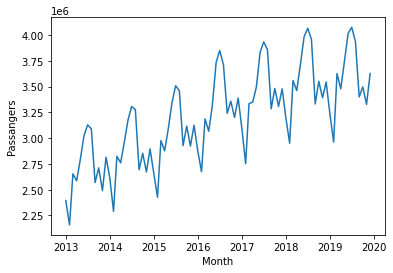

In [4]:
plt.xlabel('Month')
plt.ylabel('Passangers')
plt.plot(df)

split data 2013 - 2017 dan 2018 - 2019

In [5]:
train= df[:"2017-12-01"]
train.size

60

In [6]:
test = df["2018-01-01":]
test.size

24

Text(0.5, 1.0, 'Rollign mean & standard deviation Los Angeles')

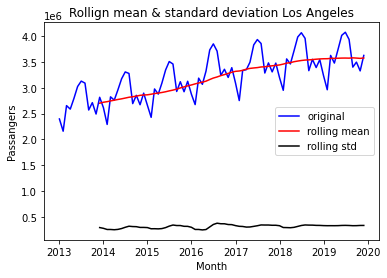

In [7]:
rolling_mean = df.rolling(window =12).mean()
rolling_std = df.rolling(window = 12).std()

plt.xlabel('Month')
plt.ylabel('Passangers')
plt.plot(df, label =  'original', color = 'blue')
plt.plot(rolling_mean, color = 'red', label = 'rolling mean')
plt.plot(rolling_std, color = 'black', label = 'rolling std')
plt.legend()
plt.title('Rollign mean & standard deviation Los Angeles')

In [8]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Passengers'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

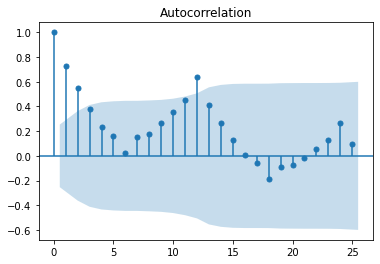

In [9]:
plot_acf(train, lags=25)
plt.show() # variable Q = 1

C:\Users\bondr\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


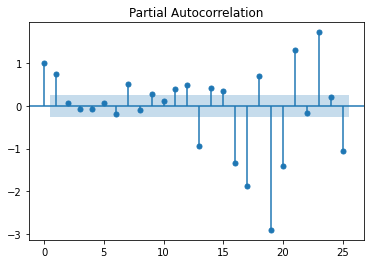

In [10]:
plot_pacf(train, lags = 25)
plt.show() #variable P = 1, sebelumnya P = 2 (salah) 

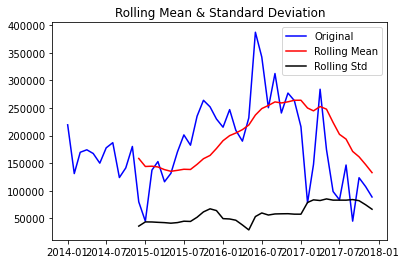

ADF Statistic: -1.3771910919101764
p-value: 0.5931608414246091
Critical Values:
	1%: -3.584828853223594
	5%: -2.9282991495198907
	10%: -2.6023438271604937


In [11]:
train12 = train.diff(12)
train12.dropna(inplace=True)
get_stationarity(train12)

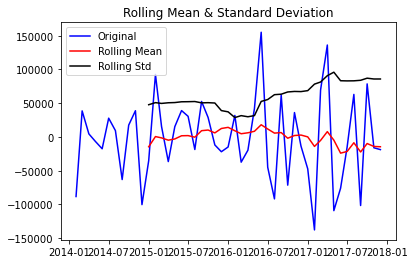

ADF Statistic: -8.286112198033246
p-value: 4.386289400809343e-13
Critical Values:
	1%: -3.584828853223594
	5%: -2.9282991495198907
	10%: -2.6023438271604937


In [12]:
train13 = train12.diff()
train13.dropna(inplace=True)
get_stationarity(train13) #Variabel D = 1

In [13]:
model = SARIMAX(train, seasonal_order=(1, 1, 1,12),order =(2,2,1)) #P,D,Q,s, p,d,q
model_fit = model.fit(disp = 0)
print(model_fit.summary())

C:\Users\bondr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\bondr\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\bondr\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                   60
Model:             SARIMAX(2, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -571.444
Date:                            Tue, 05 Jan 2021   AIC                           1154.887
Time:                                    14:56:05   BIC                           1165.859
Sample:                                01-01-2013   HQIC                          1158.997
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1944      0.168     -1.160      0.246      -0.523       0.134
ar.L2         -0.0180      0.049   

C:\Users\bondr\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
predictions = model_fit.forecast(steps = 48)

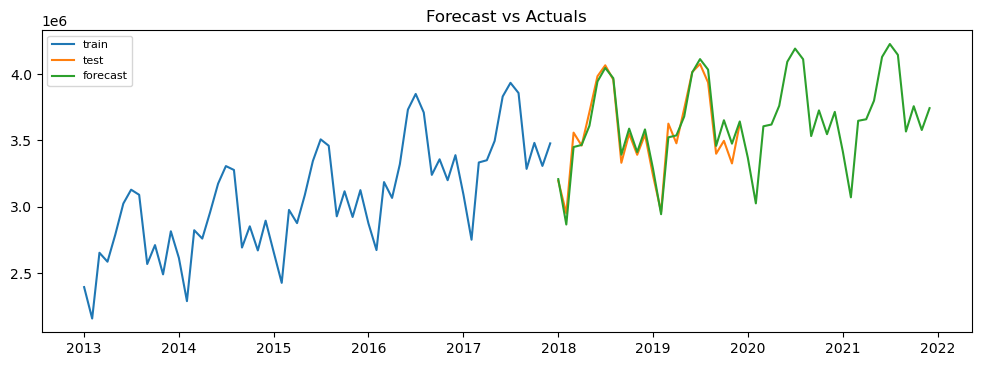

In [15]:
# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(predictions, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Evaluating the model

In [16]:
error=rmse(predictions, test['Passengers'])
error #masukan dalam persen, MAPE. biasanya untuk membandingkan model pakai MSE 

ValueError: operands could not be broadcast together with shapes (48,) (24,) 